#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

### Dowlining Data

In [ ]:
# link of the data
#http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [ ]:
# Loading AFLW2000 Data
#%%capture
#if os.path.isfile('/content/AFLW2000-3D.zip') == False:
#  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
#  !unzip /content/AFLW2000-3D.zip

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

In [5]:
# choosing random image
from google.colab.patches import cv2_imshow
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
def face_processing(image_name):
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread('/content/drive/MyDrive/AFLW2000/'+image_name +'.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      #print(dir(results.multi_face_landmarks[0].landmark[99]))
      key_points = [] 
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                key_points.append(x)
                key_points.append(y)
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
  return image , key_points

In [6]:
image , key_points = face_processing(random_file)
#cv2_imshow(image)

In [7]:
len(key_points)

936

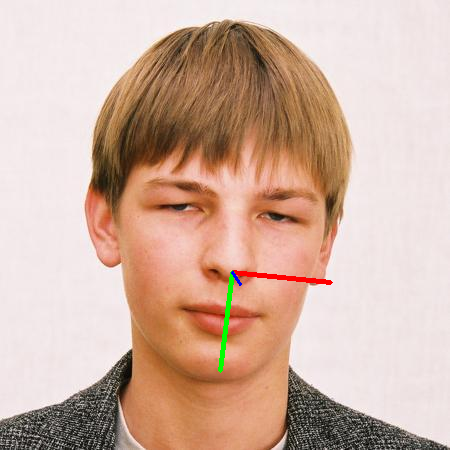

In [8]:
random_file = 'image00059'
image = cv2.imread('/content/drive/MyDrive/AFLW2000/'+random_file+'.jpg')
img , key_points = face_processing(random_file)
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/drive/MyDrive/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll,tdx=int(key_points[2] * img.shape[0]),tdy=int(key_points[3]*img.shape[1]) ))

In [9]:
# import the modules
import os
from os import listdir
 
# get the path/directory
folder_dir = '/content/drive/MyDrive/AFLW2000/'
images = []
for image in os.listdir(folder_dir):
    # check if the image ends with png
    if (image.endswith('.jpg')):
      image = image.replace('.jpg','')
      images.append(image)

In [10]:
data = []
for image in images:
  img ,key_points = face_processing(image)
  #img = cv2.resize(img, (200,200))
  #img_normalized = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  mat_file = sio.loadmat('/content/drive/MyDrive/AFLW2000/'+image+'.mat')
  # extracting the labels 3 angels
  pose_para = mat_file["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]
  key_points.extend([pitch,yaw,roll])
  data.append(key_points)

In [11]:
#len of a data record after adding the 3 labels 
len(data[0])

939

In [12]:
df = pd.DataFrame(data)

In [13]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,938
0,0.536027,0.670145,0.550545,0.605735,0.538381,0.624417,0.525298,0.540662,0.551508,0.585732,...,0.494373,0.555106,0.497574,0.643155,0.479105,0.652163,0.470306,0.027256,-0.247779,-0.010263
1,-0.541882,-1.445564,1.070782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.535756,0.674886,0.549139,0.618261,0.532575,0.635270,0.512314,0.559533,0.548158,0.600052,...,0.498843,0.533406,0.503917,0.619016,0.463167,0.624797,0.449948,-0.331991,-0.280685,-0.057327
3,0.488480,0.676522,0.479657,0.602358,0.485285,0.630002,0.463982,0.544253,0.479396,0.581587,...,0.514193,0.535371,0.515305,0.672584,0.513511,0.687354,0.497882,0.093373,0.062462,-0.125822
4,0.456775,0.709559,0.410104,0.652228,0.450343,0.660896,0.408526,0.582649,0.403161,0.634361,...,0.509434,0.474607,0.518363,0.579195,0.482681,0.590529,0.470266,-0.446169,0.684181,-0.270866


In [14]:
df.isna().sum()

0        0
1        0
2        0
3      147
4      147
      ... 
934    147
935    147
936    147
937    147
938    147
Length: 939, dtype: int64

In [15]:
df.dropna(inplace=True)

In [16]:
df.isna().sum().sum()

0

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1853 entries, 0 to 1999
Columns: 939 entries, 0 to 938
dtypes: float64(939)
memory usage: 13.3 MB


In [18]:
df_features = df.iloc[:,:-3]
df_labels = df.iloc[:,-3:]

In [19]:
df_labels.columns=['pitch','yaw','roll']

In [20]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.536027,0.670145,0.550545,0.605735,0.538381,0.624417,0.525298,0.540662,0.551508,0.585732,...,0.564150,0.489764,0.557016,0.494373,0.555106,0.497574,0.643155,0.479105,0.652163,0.470306
2,0.535756,0.674886,0.549139,0.618261,0.532575,0.635270,0.512314,0.559533,0.548158,0.600052,...,0.541171,0.491597,0.534570,0.498843,0.533406,0.503917,0.619016,0.463167,0.624797,0.449948
3,0.488480,0.676522,0.479657,0.602358,0.485285,0.630002,0.463982,0.544253,0.479396,0.581587,...,0.558678,0.510932,0.544457,0.514193,0.535371,0.515305,0.672584,0.513511,0.687354,0.497882
4,0.456775,0.709559,0.410104,0.652228,0.450343,0.660896,0.408526,0.582649,0.403161,0.634361,...,0.495700,0.499583,0.485036,0.509434,0.474607,0.518363,0.579195,0.482681,0.590529,0.470266
5,0.503842,0.693606,0.488899,0.630223,0.498043,0.646732,0.468165,0.554942,0.485042,0.608703,...,0.537393,0.477285,0.526253,0.485155,0.519191,0.491338,0.631925,0.447866,0.640221,0.437037


In [21]:
df_labels.head()

,pitch,yaw,roll
0,0.027256,-0.247779,-0.010263
2,-0.331991,-0.280685,-0.057327
3,0.093373,0.062462,-0.125822
4,-0.446169,0.684181,-0.270866
5,-0.241359,0.205732,-0.150232


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train_features,test_features,train_labels,test_labels = train_test_split(df_features,df_labels, test_size=0.1, random_state=42)

In [24]:
train_features.shape

(1667, 936)

drawing the labels to get insights

In [25]:
import matplotlib.pyplot as plt

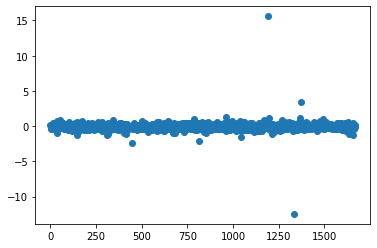

In [26]:
plt.scatter(np.arange(train_labels.shape[0]),train_labels['pitch'])

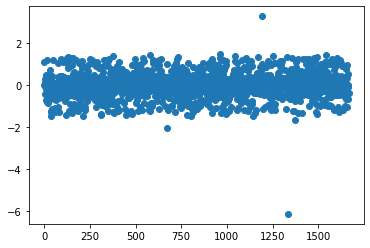

In [27]:
plt.scatter(np.arange(train_labels.shape[0]),train_labels['yaw'])

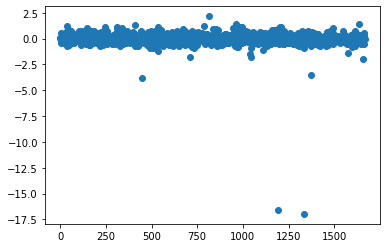

In [28]:
plt.scatter(np.arange(train_labels.shape[0]),train_labels['roll'])

training the data

In [29]:
from sklearn.svm import SVR
svr_pitch = SVR()
svr_pitch.fit(train_features, train_labels['pitch'])

SVR()

In [30]:
svr_pitch.score(test_features,test_labels['pitch'])

0.7633624555616493

In [31]:
svr_yaw = SVR()
svr_yaw.fit(train_features, train_labels['yaw'])

SVR()

In [32]:
svr_yaw.score(test_features,test_labels['yaw'])

0.9605297741050105

In [33]:
svr_roll= SVR()
svr_roll.fit(train_features, train_labels['roll'])

SVR()

In [34]:
svr_roll.score(test_features,test_labels['roll'])

0.8789427727415101

In [35]:
#saving the models
import joblib
joblib.dump(svr_pitch, 'svr_pitch.pkl')
joblib.dump(svr_yaw, 'svr_yaw.pkl')
joblib.dump(svr_roll, 'svr_roll.pkl')

['svr_roll.pkl']

In [36]:
# Load the model from the file
#svr_pitch = joblib.load('svr_pitch.pkl')
#svr_yaw = joblib.load('svr_yaw.pkl')
#svr_roll = joblib.load('svr_roll.pkl')

Making predictions

In [37]:
#test image face processing
def test_face_processing(image_path):
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread(image_path)
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      #print(dir(results.multi_face_landmarks[0].landmark[99]))
      key_points = [] 
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                key_points.append(x)
                key_points.append(y)
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
  return image , key_points

In [38]:
#predictions and drawing
def predsave(image_path):
  img ,key_points = test_face_processing(image_path)
  if(len(key_points)>0):
    pitch = svr_pitch.predict([key_points])
    yaw = svr_yaw.predict([key_points])
    roll = svr_roll.predict([key_points])
    image = cv2.imread(image_path)
    x1 = int(key_points[2]*image.shape[1])
    y1 = int(key_points[3]*image.shape[0])
    x152 = int(key_points[304]*image.shape[1])
    y152 = int(key_points[305]*image.shape[0])
    s = ( (y152-y1)**2 + (x152-x1)**2)**0.5
    image = draw_axis(image,pitch,yaw,roll,
                        tdx=x1,
                        tdy=y1,
                        size = s
                        )
    cv2.imwrite(image_path, (draw_axis(image,pitch,yaw,roll,
                        tdx=x1,
                        tdy=y1,
                        size = s
                        )))
    
    
   
    return pitch,yaw,roll,image
  else:
    return

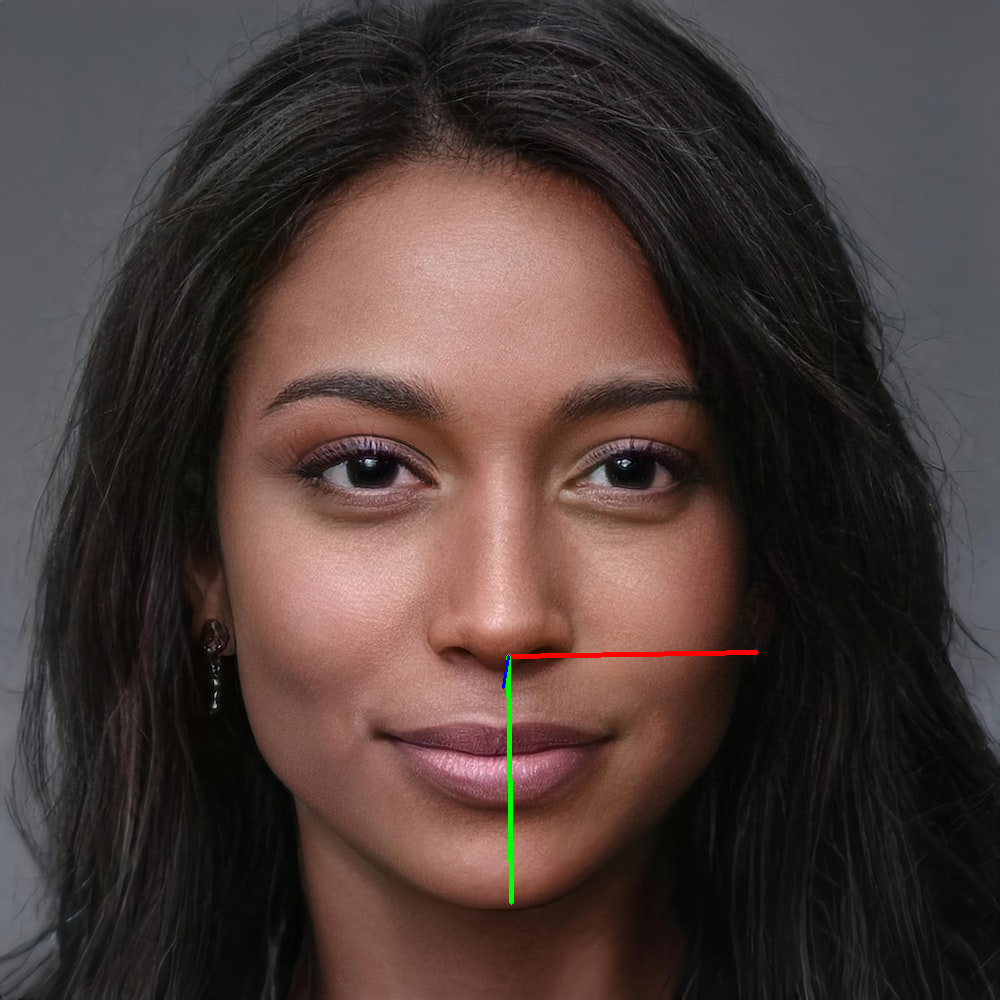

In [39]:
# pred('/content/test1.jpg')
pitch,yaw,roll,image = predsave('/content/drive/MyDrive/ML1/test1.jpg')
cv2_imshow(image)

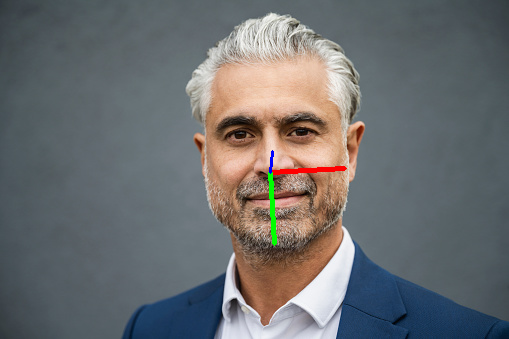

In [40]:
# pred('/content/test3.jpg')
pitch,yaw,roll,image = predsave('/content/drive/MyDrive/ML1/test3.jpg')
cv2_imshow(image)

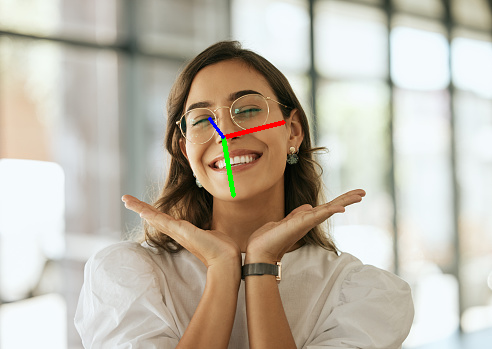

In [41]:
# pred('/content/test2.jpg')
pitch,yaw,roll,image=predsave('/content/drive/MyDrive/ML1/test2.jpg')
cv2_imshow(image)

applying on video

In [42]:
video_path = '/content/drive/MyDrive/ML1/test_video.mp4'
# Open the video file
video = cv2.VideoCapture(video_path)
width= int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Initialize a counter for the frames
frame_count = 0
frames = []
# Loop through the frames of the video
while True:
    # Read the next frame
    ret, frame = video.read()
    #frame=cv2.rotate(frame, cv2.ROTATE_180)
    # If the frame is not successfully read, break the loop
    if not ret:
        break

    # Do something with the frame, for example, save it as an image
    cv2.imwrite("/content/drive/MyDrive/ML1/videoToimage/image_%d.jpg" % frame_count, frame)
    predsave("/content/drive/MyDrive/ML1/videoToimage/image_%d.jpg" % frame_count)
    # if pred.shape != np.array([-1]).shape:
    frames.append("/content/drive/MyDrive/ML1/videoToimage/image_%d.jpg" % frame_count)

    # Increment the frame counter
    frame_count += 1

# Release the video file
video.release()

In [43]:
out = cv2.VideoWriter('out1.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
for frame in frames:
    out.write(cv2.imread(frame))
out.release()